In [209]:
from pyspark.sql.window import Window
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import col, lead, log

In [210]:
# Initializes Spark session with MongoDB connector
jar_files_path = "file:///C:/Users/llucp/spark_jars/"

jar_files = [
    "mongo-spark-connector_2.12-10.1.1.jar",
    "mongodb-driver-core-4.10.1.jar",
    "mongodb-driver-sync-4.10.1.jar",
    "bson-4.10.1.jar"
]

MONGO_URI = "mongodb://localhost:27017/"
DB_NAME = "tfg"
FORMATTING_TRADE = "formatting_trade"
FORMATTING_LOB = "formatting_lob"
EXPLOITATION = "exploitation"

spark = (
    SparkSession.builder
    .appName("FormattedZone")
    .config("spark.jars", ",".join([jar_files_path + jar for jar in jar_files]))
    .config("spark.mongodb.read.connection.uri", MONGO_URI)
    .config("spark.mongodb.write.connection.uri", MONGO_URI)
    .config("spark.mongodb.read.database", DB_NAME)
    .config("spark.mongodb.write.database", DB_NAME)
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

spark.sparkContext.setLogLevel("ERROR")

In [211]:
def load_trade() -> DataFrame:
    """
    Loads formatting zone trade data and returns it as a dataframe.
    """
    trades = (
        spark.read.format("mongodb")
        .option("database", DB_NAME)
        .option("collection", FORMATTING_TRADE)
        .load()
    )

    return trades

In [212]:
def calculate_forward_logret(df: DataFrame, lag: int, N: int) -> DataFrame:
    """
    Calculates forward log returns of last traded price over N periods, accounting for a decision lag.
    """
    w = Window.orderBy("timestamp")
    base = lead(col("last_traded_price"), lag).over(w)
    future = lead(col("last_traded_price"), lag + N).over(w)

    return df.withColumn(f"fwd_logret_{N}", log(future) - log(base))

In [213]:
trades = load_trade()

# Given a list of forward logret horizons, calculate and add them to the dataframe
fwd_logret_horizons = [2, 3, 4, 5, 10, 20, 40, 60, 120, 240]
lag = 1  # Decision lag of 1 period

for N in fwd_logret_horizons:
    trades = calculate_forward_logret(trades, lag, N)

In [214]:
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox
from sklearn.mixture import GaussianMixture
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as np
import re

In [215]:
cols = [f"fwd_logret_{N}" for N in fwd_logret_horizons]
df = trades.select(*cols).dropna().toPandas()

In [216]:
def extract_fwd_logret_horizon(colname: str) -> int:
    m = re.search(r"(\d+)$", colname)

    if not m:
        raise ValueError(f"Column {colname} does not end with a number (horizon).")
    
    return int(m.group(1))

In [217]:
def apply_stride_fwd_logret(df: pd.DataFrame, cols: list[str]) -> dict[str, pd.Series]:
    """
    Return dict of stride-sampled Series per forward-return column.
    """
    out = {}

    for c in cols:
        N = extract_fwd_logret_horizon(c)
        out[c] = df[c].iloc[::N].dropna().reset_index(drop=True)

    return out

In [218]:
def summarize_series(s: pd.Series) -> dict:
    s = s.dropna().astype(float)
    n = int(s.size)
    mean = float(s.mean())
    std  = float(s.std(ddof=1)) if n > 1 else np.nan
    skew = float(stats.skew(s, bias=False, nan_policy="omit")) if n > 2 else np.nan
    kurt = float(stats.kurtosis(s, fisher=True, bias=False, nan_policy="omit")) if n > 3 else np.nan  # excess kurtosis

    # Normality tests (note: Shapiro valid up to ~5000 obs)
    if 3 <= n <= 5000:
        sh_stat, sh_p = stats.shapiro(s)
        
    else:
        sh_stat, sh_p = (np.nan, np.nan)

    jb_stat, jb_p = stats.jarque_bera(s) if n >= 2 else (np.nan, np.nan)

    try:
        ad = stats.anderson(s, dist="norm")
        ad_stat = float(ad.statistic)

        # Report whether it exceeds 5% critical value
        ad_crit_5 = float(ad.critical_values[ad.significance_level.tolist().index(5.0)])
        ad_reject_5 = ad_stat > ad_crit_5

    except Exception:
        ad_stat, ad_crit_5, ad_reject_5 = (np.nan, np.nan, np.nan)

    return {
        "n": n,
        "mean": mean,
        "std": std,
        "skew": skew,
        "excess_kurtosis": kurt,
        "shapiro_stat": sh_stat,
        "shapiro_p": sh_p,
        "jarque_bera_stat": float(jb_stat) if jb_stat==jb_stat else np.nan,
        "jarque_bera_p": float(jb_p) if jb_p==jb_p else np.nan,
        "anderson_stat": ad_stat,
        "anderson_crit_5pct": ad_crit_5,
        "anderson_reject_5pct": bool(ad_reject_5) if ad_reject_5==ad_reject_5 else np.nan,
    }

In [219]:
def summarize_normality_test_stride_fwd_logret(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    # Applies the stride in each column independently
    stride_dict = apply_stride_fwd_logret(df, cols)
    rows = []

    for c, s in stride_dict.items():
        N = extract_fwd_logret_horizon(c)
        stats_row = summarize_series(s)
        stats_row.update({"column": c, "horizon_N": N})
        rows.append(stats_row)

    out = pd.DataFrame(rows).sort_values("horizon_N").reset_index(drop=True)

    return out

In [220]:
def summarize_normality_test_fwd_logret(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    """
    Summarizes normality tests for specified forward log return columns.
    """
    rows = []

    for c in cols:
        s = df[c].dropna().astype(float)
        N = extract_fwd_logret_horizon(c)
        stats_row = summarize_series(s)
        stats_row.update({"column": c, "horizon_N": N})
        rows.append(stats_row)

    out = pd.DataFrame(rows).sort_values("horizon_N").reset_index(drop=True)

    return out

In [221]:
stride_summary = summarize_normality_test_stride_fwd_logret(df, cols)
stride_summary

,n,mean,std,skew,excess_kurtosis,shapiro_stat,shapiro_p,jarque_bera_stat,jarque_bera_p,anderson_stat,anderson_crit_5pct,anderson_reject_5pct,column,horizon_N
0,1942,-0.000008,0.000310,0.134284,2.795186,0.966617,8.517215e-21,633.393020,2.887043e-138,13.022153,0.785,True,fwd_logret_2,2
1,1295,-0.000012,0.000377,0.078896,3.082043,0.969545,7.069996e-16,508.411152,3.980348e-111,6.823576,0.785,True,fwd_logret_3,3
2,971,-0.000016,0.000429,0.339191,2.969601,0.965546,2.199339e-14,370.210827,4.071369e-81,5.554531,0.784,True,fwd_logret_4,4
3,777,-0.000019,0.000487,0.249259,2.662706,0.972873,7.969978e-11,233.295064,2.190890e-51,3.724365,0.783,True,fwd_logret_5,5
4,389,-0.000038,0.000675,0.330544,1.848800,0.982970,1.517398e-04,60.113779,8.840133e-14,0.718129,0.779,False,fwd_logret_10,10
5,195,-0.000074,0.000930,-0.355603,0.287883,0.990380,2.178170e-01,4.554197,1.025814e-01,0.570929,0.772,False,fwd_logret_20,20
6,98,-0.000139,0.001278,-0.063648,0.063628,0.995496,9.871011e-01,0.064149,9.684343e-01,0.184964,0.758,False,fwd_logret_40,40
7,65,-0.000222,0.001609,-0.346409,0.853017,0.984555,5.946197e-01,2.559394,2.781216e-01,0.260699,0.746,False,fwd_logret_60,60
8,33,-0.000430,0.002516,-1.110497,3.735039,0.920002,1.832356e-02,18.681158,8.778858e-05,0.744245,0.717,True,fwd_logret_120,120
9,17,-0.000765,0.003230,-2.127752,6.224747,0.793672,1.663483e-03,23.138936,9.450264e-06,0.938138,0.685,True,fwd_logret_240,240


In [222]:
summary = summarize_normality_test_fwd_logret(df, cols)
summary

,n,mean,std,skew,excess_kurtosis,shapiro_stat,shapiro_p,jarque_bera_stat,jarque_bera_p,anderson_stat,anderson_crit_5pct,anderson_reject_5pct,column,horizon_N
0,3884,-0.000008,0.000314,0.112273,3.624805,0.956861,1.843102e-32,2127.237891,0.000000e+00,33.456831,0.786,True,fwd_logret_2,2
1,3884,-0.000012,0.000379,0.142599,3.113864,0.965489,1.554753e-29,1576.723411,0.000000e+00,25.074062,0.786,True,fwd_logret_3,3
2,3884,-0.000016,0.000432,0.206263,3.138960,0.965526,1.604588e-29,1616.405918,0.000000e+00,23.020905,0.786,True,fwd_logret_4,4
3,3884,-0.000019,0.000480,0.218852,2.871899,0.969128,3.965216e-28,1360.883909,3.074780e-296,20.588996,0.786,True,fwd_logret_5,5
4,3884,-0.000038,0.000679,0.325476,3.043095,0.971707,4.720870e-27,1561.794759,0.000000e+00,13.361735,0.786,True,fwd_logret_10,10
5,3884,-0.000075,0.000893,-0.030531,0.460953,0.997262,1.848270e-06,34.670745,2.960353e-08,1.413140,0.786,True,fwd_logret_20,20
6,3884,-0.000142,0.001227,-0.276342,0.416383,0.993416,2.386269e-12,77.173486,1.745784e-17,2.876345,0.786,True,fwd_logret_40,40
7,3884,-0.000213,0.001518,-0.458723,1.044314,0.983564,7.481435e-21,311.630164,2.139783e-68,5.897718,0.786,True,fwd_logret_60,60
8,3884,-0.000427,0.002137,-0.629438,1.704666,0.973844,4.208340e-26,724.479564,4.800224e-158,12.021970,0.786,True,fwd_logret_120,120
9,3884,-0.000829,0.002949,-0.717582,1.639314,0.950900,3.173511e-34,766.036643,4.542098e-167,53.099373,0.786,True,fwd_logret_240,240


In [223]:
def heteroskedasticity_report_stride(
    df: pd.DataFrame,
    cols: list[str],
    arch_lags: int = 10,
    lb_lags: tuple[int, int] = (10, 20),
    min_n: int = 50,
) -> pd.DataFrame:
    """
    For each forward-return column named '..._<N>', take stride=N samples and run:
      - ARCH LM test (nlags=arch_lags)
      - Ljung–Box on squared returns (lags in lb_lags)

    Returns a tidy DataFrame with decisions and p-values.
    """
    stride_dict = apply_stride_fwd_logret(df, cols)
    rows = []

    for c, s in stride_dict.items():
    # for c in cols:
        # s = df[c].dropna().astype(float)
        N = extract_fwd_logret_horizon(c)
        n = int(s.size)
        
        if n < max(min_n, arch_lags + 5):
            rows.append({
                "column": c, "horizon_N": N, "n_stride": n,
                "arch_lm_stat": np.nan, "arch_lm_p": np.nan, "arch_reject_5pct": np.nan,
                "lb_sq_lag1_p": np.nan, "lb_sq_lagA_p": np.nan, "lb_sq_lagB_p": np.nan,
                "lb_reject_any_5pct": np.nan,
                "note": f"insufficient n (<{max(min_n, arch_lags + 5)})"
            })
            continue

        # ARCH LM on raw returns (tests conditional heteroskedasticity)
        arch_stat, arch_p, _, _ = het_arch(s.values, nlags=arch_lags)
        arch_reject = bool(arch_p < 0.05)

        # Ljung–Box on squared returns (variance autocorrelation)
        s2 = (s.values - s.values.mean())**2
        la, lb = lb_lags
        lb1 = acorr_ljungbox(s2, lags=[1], return_df=True)["lb_pvalue"].iloc[-1]
        lbA = acorr_ljungbox(s2, lags=[la], return_df=True)["lb_pvalue"].iloc[-1]
        lbB = acorr_ljungbox(s2, lags=[lb], return_df=True)["lb_pvalue"].iloc[-1]
        lb_reject = bool((lb1 < 0.05) or (lbA < 0.05) or (lbB < 0.05))

        rows.append({
            "column": c, "horizon_N": N, "n_stride": n,
            "arch_lm_stat": float(arch_stat), "arch_lm_p": float(arch_p), "arch_reject_5pct": arch_reject,
            "lb_sq_lag1_p": float(lb1), "lb_sq_lagA_p": float(lbA), "lb_sq_lagB_p": float(lbB),
            "lb_reject_any_5pct": lb_reject,
            "note": ""
        })

    out = pd.DataFrame(rows).sort_values("horizon_N").reset_index(drop=True)

    def verdict(row):
        if row["note"]:
            return "insufficient sample"
        flags = []
        if row["arch_reject_5pct"]: flags.append("ARCH")
        if row["lb_reject_any_5pct"]: flags.append("LB(sq)")
        return "heteroskedasticity detected: " + "+".join(flags) if flags else "no evidence at 5%"

    out["verdict"] = out.apply(verdict, axis=1)

    return out

In [224]:
report = heteroskedasticity_report_stride(df, cols, arch_lags=10, lb_lags=(10,20))
display(report)

,column,horizon_N,n_stride,arch_lm_stat,arch_lm_p,arch_reject_5pct,lb_sq_lag1_p,lb_sq_lagA_p,lb_sq_lagB_p,lb_reject_any_5pct,note,verdict
0,fwd_logret_2,2,1942,162.893994,8.182691e-30,True,3.285271e-16,2.908554e-58,1.302541e-128,True,,heteroskedasticity detected: ARCH+LB(sq)
1,fwd_logret_3,3,1295,99.835541,5.878748e-17,True,8.049730e-10,5.114655e-31,1.775492e-62,True,,heteroskedasticity detected: ARCH+LB(sq)
2,fwd_logret_4,4,971,94.391323,7.180541e-16,True,9.672000e-15,1.326413e-31,4.839868e-46,True,,heteroskedasticity detected: ARCH+LB(sq)
3,fwd_logret_5,5,777,95.091214,5.208697e-16,True,9.843714e-09,8.316055e-33,2.858918e-46,True,,heteroskedasticity detected: ARCH+LB(sq)
4,fwd_logret_10,10,389,52.329509,9.915152e-08,True,7.193071e-02,4.513673e-10,1.637125e-08,True,,heteroskedasticity detected: ARCH+LB(sq)
5,fwd_logret_20,20,195,18.535192,4.657942e-02,True,5.670965e-01,1.774453e-02,4.852867e-04,True,,heteroskedasticity detected: ARCH+LB(sq)
6,fwd_logret_40,40,98,32.324360,3.535153e-04,True,1.226916e-06,1.027077e-06,1.278108e-04,True,,heteroskedasticity detected: ARCH+LB(sq)
7,fwd_logret_60,60,65,9.278610,5.058825e-01,False,7.130778e-02,3.298695e-01,7.502546e-01,False,,no evidence at 5%
8,fwd_logret_120,120,33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,insufficient n (<50),insufficient sample
9,fwd_logret_240,240,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,insufficient n (<50),insufficient sample


In [225]:
def safe_kde(x):
    # returns (xs, kde(xs)) or (None, None) if KDE fails
    try:
        kde = stats.gaussian_kde(x)
        lo, hi = np.percentile(x, 0.5), np.percentile(x, 99.5)
        xs = np.linspace(lo, hi, 400)
        return xs, kde(xs)
    except Exception:
        return None, None

In [226]:
def fit_normal(x):
    mu = np.mean(x)
    sigma = np.std(x, ddof=1)
    return {"name":"Normal", "mu":mu, "sigma":sigma}

def fit_student_t(x):
    # scipy's t.fit returns (df, loc, scale)
    df, loc, scale = stats.t.fit(x)
    return {"name":"Student-t", "df":df, "mu":loc, "sigma":scale}

def fit_gmm(x, K=3, n_init=5, random_state=0):
    x2 = np.asarray(x).reshape(-1,1)
    gmm = GaussianMixture(n_components=K, covariance_type="full",
                          n_init=n_init, random_state=random_state)
    gmm.fit(x2)
    return {"name":f"GMM(K={K})", "model":gmm}


In [227]:
def loglik_normal(x, mu, sigma):
    return np.sum(stats.norm.logpdf(x, loc=mu, scale=sigma))

def loglik_student_t(x, df, mu, sigma):
    return np.sum(stats.t.logpdf(x, df=df, loc=mu, scale=sigma))

def loglik_gmm(x, gmm: GaussianMixture):
    x2 = np.asarray(x).reshape(-1,1)
    # sklearn returns average loglike per sample; multiply by n for total
    return float(gmm.score(x2) * len(x))

def aic_bic(loglik, k, n):
    # k = number of free parameters; n = sample size
    aic = 2*k - 2*loglik
    bic = np.log(n)*k - 2*loglik
    return aic, bic

In [228]:
def plot_empirical_vs_parametrics(x, fits, title="", show_qq=True):
    x = np.asarray(x)
    n = len(x)
    fig_h = 3.2 if not show_qq else 6.5
    fig, ax = plt.subplots(2 if show_qq else 1, 1, figsize=(8, fig_h))
    ax0 = ax[0] if show_qq else ax

    # Empirical histogram
    ax0.hist(x, bins=60, density=True, alpha=0.4, label="Empirical (hist)")
    xs_kde, ys_kde = safe_kde(x)
    if xs_kde is not None:
        ax0.plot(xs_kde, ys_kde, label="Empirical KDE")

    # Overlay PDFs
    xs = np.linspace(np.percentile(x,0.5), np.percentile(x,99.5), 400)
    info_lines = []

    for f in fits:
        if f["name"] == "Normal":
            pdf = stats.norm.pdf(xs, loc=f["mu"], scale=f["sigma"])
            ll = loglik_normal(x, f["mu"], f["sigma"])
            k = 2
            aic, bic = aic_bic(ll, k, n)
            ax0.plot(xs, pdf, label=f"Normal PDF")
            info_lines.append(f"Normal  AIC={aic:.1f}  BIC={bic:.1f}")
        elif f["name"] == "Student-t":
            pdf = stats.t.pdf(xs, df=f["df"], loc=f["mu"], scale=f["sigma"])
            ll = loglik_student_t(x, f["df"], f["mu"], f["sigma"])
            k = 3
            aic, bic = aic_bic(ll, k, n)
            ax0.plot(xs, pdf, label=f"Student-t PDF")
            info_lines.append(f"Student-t(df={f['df']:.1f})  AIC={aic:.1f}  BIC={bic:.1f}")
        elif f["name"].startswith("GMM"):
            gmm = f["model"]
            # mixture PDF = sum pi_k * N(xs | mu_k, sigma_k^2)
            pdf = np.zeros_like(xs)
            for w, m, v in zip(gmm.weights_, gmm.means_.ravel(), gmm.covariances_.ravel()):
                pdf += w * stats.norm.pdf(xs, loc=m, scale=np.sqrt(v))
            ll = loglik_gmm(x, gmm)
            K = gmm.n_components
            k = 3*K - 1
            aic, bic = aic_bic(ll, k, n)
            ax0.plot(xs, pdf, label=f"GMM(K={K}) PDF")
            info_lines.append(f"GMM(K={K})  AIC={aic:.1f}  BIC={bic:.1f}")

    ax0.set_title(title or "Empirical vs Parametric PDFs")
    ax0.set_xlabel("return")
    ax0.set_ylabel("density")
    ax0.legend(loc="best")

    if show_qq:
        ax1 = ax[1]
        # Q–Q vs Normal (left axis)
        stats.probplot(x, dist="norm", plot=ax1)
        ax1.set_title("Q–Q vs Normal")

        # Add a small text box with AIC/BIC rankings
        txt = "\n".join(info_lines)
        ax1.text(0.02, 0.02, txt, transform=ax1.transAxes, fontsize=9,
                 va="bottom", ha="left",
                 bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"))

    plt.tight_layout()
    plt.show()

In [229]:
def analyze_stride_column(df: pd.DataFrame, col: str, s, gmm_components=(3,)):
    N = extract_fwd_logret_horizon(col)
    
    if len(s) < 50:
        print(f"[{col}] insufficient stride samples ({len(s)})"); 
        return

    fits = []
    # Fit families
    fits.append(fit_normal(s))
    try:
        fits.append(fit_student_t(s))
    except Exception as e:
        print(f"[{col}] Student-t fit failed: {e}")
    for K in gmm_components:
        try:
            fits.append(fit_gmm(s, K=K))
        except Exception as e:
            print(f"[{col}] GMM(K={K}) fit failed: {e}")

    # Plot
    title = f"{col} — stride (N={N}), n={len(s)}"
    plot_empirical_vs_parametrics(s, fits, title=title, show_qq=True)

    # Print AIC/BIC table
    rows = []
    n = len(s)
    for f in fits:
        if f["name"] == "Normal":
            ll = loglik_normal(s, f["mu"], f["sigma"]); k=2
        elif f["name"] == "Student-t":
            ll = loglik_student_t(s, f["df"], f["mu"], f["sigma"]); k=3
        else:  # GMM
            ll = loglik_gmm(s, f["model"]); K = f["model"].n_components; k=3*K-1
        aic, bic = aic_bic(ll, k, n)
        rows.append({"model": f["name"], "loglik": ll, "k": k, "AIC": aic, "BIC": bic})
    display(pd.DataFrame(rows).sort_values("BIC"))


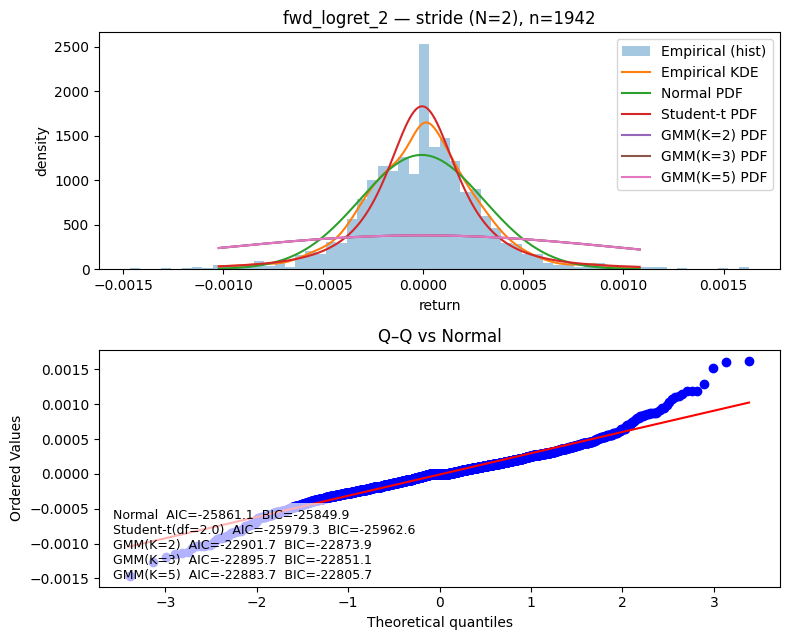

,model,loglik,k,AIC,BIC
1,Student-t,12992.660772,3,-25979.321545,-25962.607124
0,Normal,12932.538662,2,-25861.077324,-25849.934377
2,GMM(K=2),11455.854711,5,-22901.709422,-22873.852054
3,GMM(K=3),11455.854714,8,-22895.709429,-22851.137639
4,GMM(K=5),11455.854707,14,-22883.709414,-22805.708783


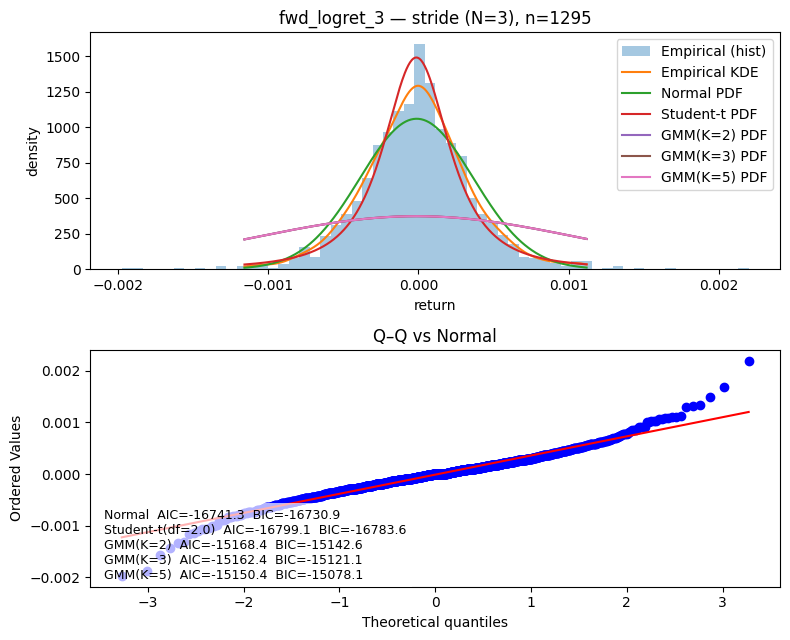

,model,loglik,k,AIC,BIC
1,Student-t,8402.549612,3,-16799.099224,-16783.600426
0,Normal,8372.626700,2,-16741.253400,-16730.920868
2,GMM(K=2),7589.201171,5,-15168.402342,-15142.571012
3,GMM(K=3),7589.201189,8,-15162.402378,-15121.072250
4,GMM(K=5),7589.201158,14,-15150.402316,-15078.074592


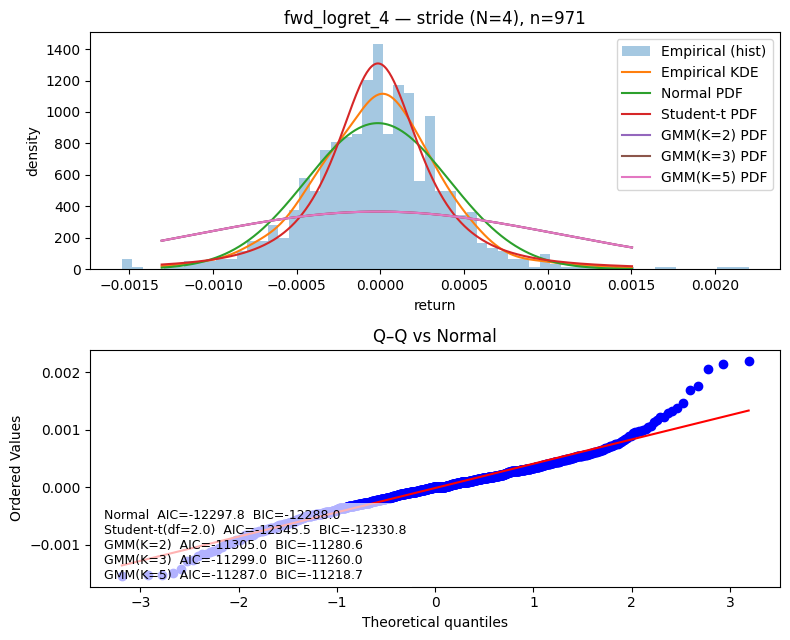

,model,loglik,k,AIC,BIC
1,Student-t,6175.726346,3,-12345.452693,-12330.817714
0,Normal,6150.885645,2,-12297.771290,-12288.014637
2,GMM(K=2),5657.513975,5,-11305.027949,-11280.636317
3,GMM(K=3),5657.513981,8,-11299.027962,-11260.001350
4,GMM(K=5),5657.513986,14,-11287.027973,-11218.731402


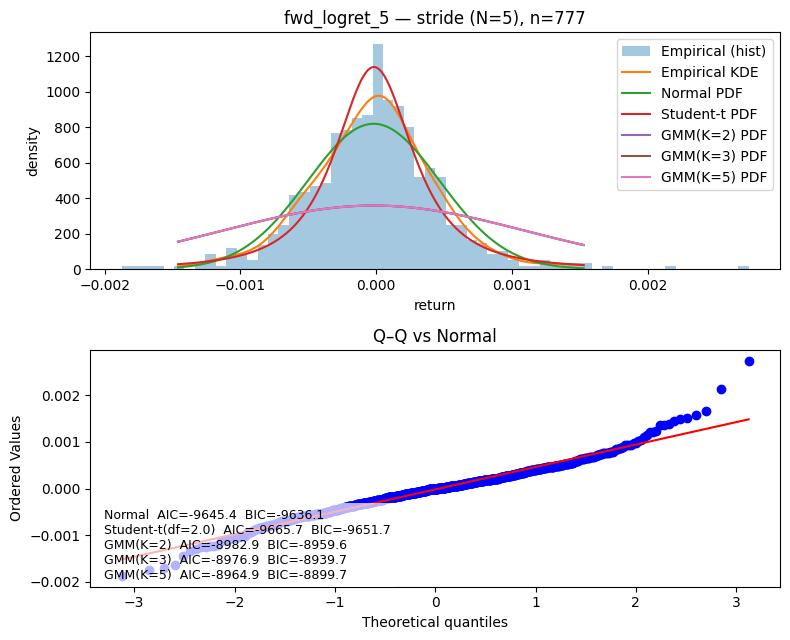

,model,loglik,k,AIC,BIC
1,Student-t,4835.852284,3,-9665.704568,-9651.738246
0,Normal,4824.724896,2,-9645.449793,-9636.138912
2,GMM(K=2),4496.452594,5,-8982.905188,-8959.627986
3,GMM(K=3),4496.452619,8,-8976.905238,-8939.661715
4,GMM(K=5),4496.452641,14,-8964.905283,-8899.729118


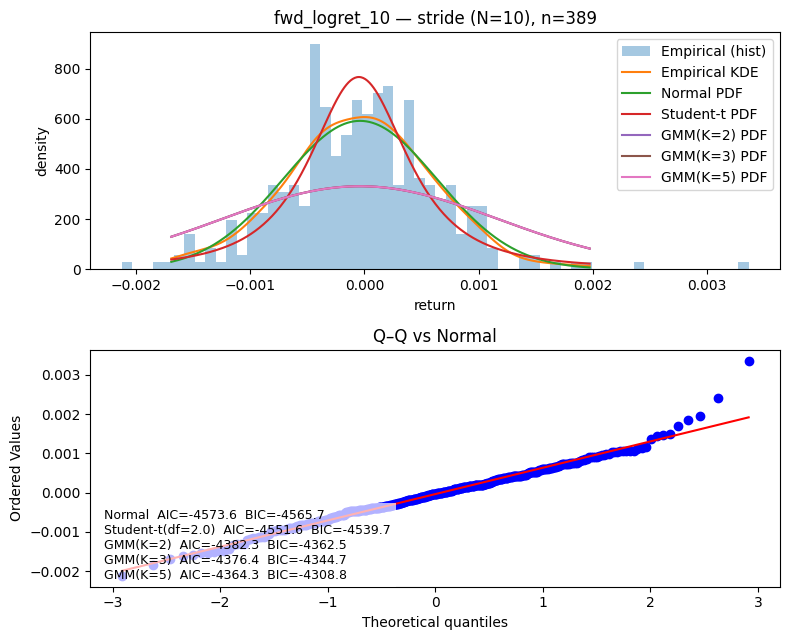

,model,loglik,k,AIC,BIC
0,Normal,2288.820930,2,-4573.641859,-4565.714701
1,Student-t,2278.802422,3,-4551.604844,-4539.714106
2,GMM(K=2),2196.160169,5,-4382.320339,-4362.502442
3,GMM(K=3),2196.198115,8,-4376.396230,-4344.687595
4,GMM(K=5),2196.158478,14,-4364.316956,-4308.826845


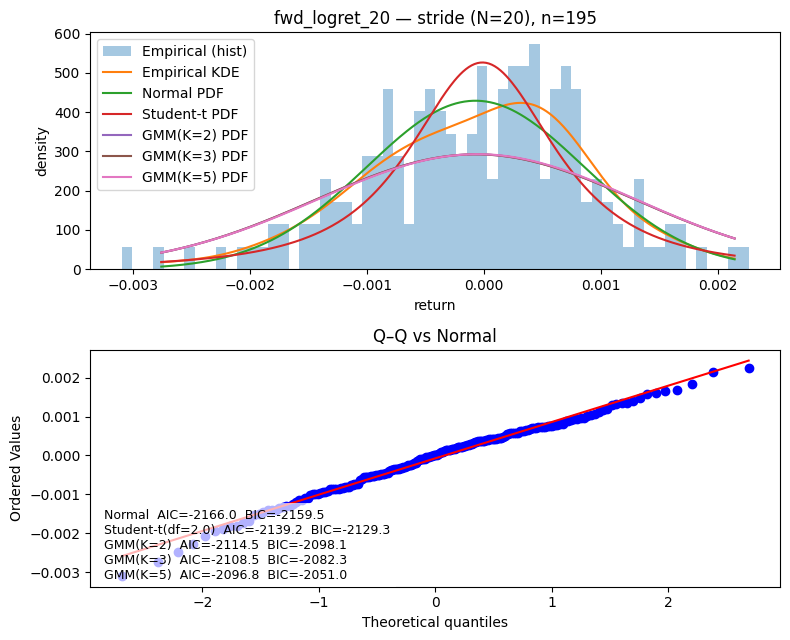

,model,loglik,k,AIC,BIC
0,Normal,1084.998747,2,-2165.997495,-2159.451496
1,Student-t,1072.580604,3,-2139.161207,-2129.342208
2,GMM(K=2),1062.252783,5,-2114.505565,-2098.140568
3,GMM(K=3),1062.226384,8,-2108.452768,-2082.268771
4,GMM(K=5),1062.394072,14,-2096.788144,-2050.966150


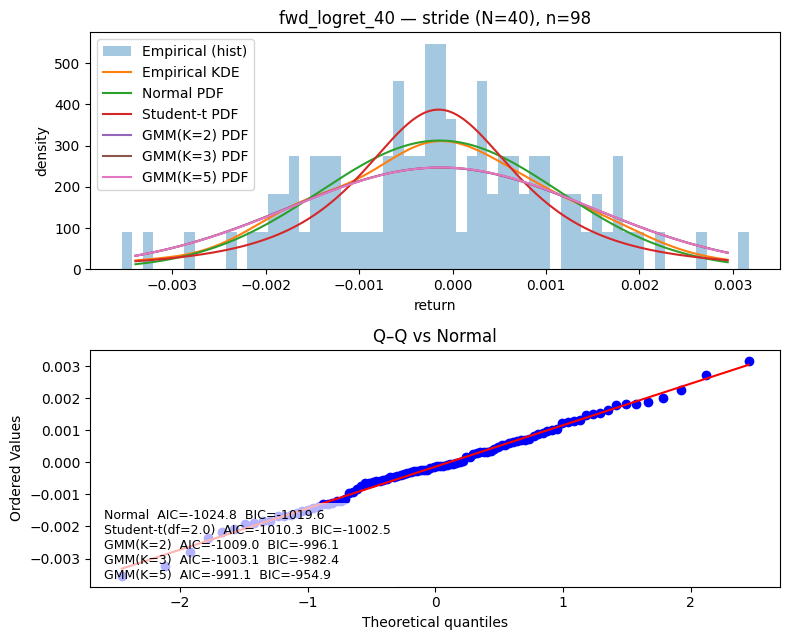

,model,loglik,k,AIC,BIC
0,Normal,514.393596,2,-1024.787192,-1019.617257
1,Student-t,508.145300,3,-1010.290600,-1002.535697
2,GMM(K=2),509.523841,5,-1009.047682,-996.122845
3,GMM(K=3),509.531471,8,-1003.062941,-982.383202
4,GMM(K=5),509.543406,14,-991.086812,-954.897267


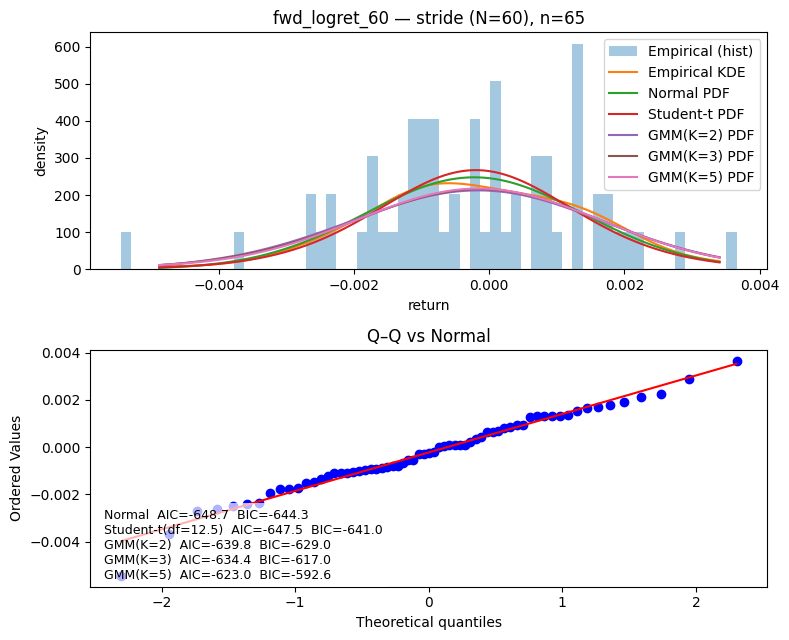

,model,loglik,k,AIC,BIC
0,Normal,326.347492,2,-648.694985,-644.346210
1,Student-t,326.751967,3,-647.503933,-640.980772
2,GMM(K=2),324.921675,5,-639.843349,-628.971413
3,GMM(K=3),325.222453,8,-634.444907,-617.049808
4,GMM(K=5),325.511440,14,-623.022880,-592.581459


[fwd_logret_120] insufficient stride samples (33)
[fwd_logret_240] insufficient stride samples (17)


In [230]:
stride_dict = apply_stride_fwd_logret(df, cols)

for c, s in stride_dict.items():
    analyze_stride_column(df, c, s, gmm_components=(2,3,5))